In [1]:
#Created By    : Andrew Kramer
#Creation Date : 20 September 2022
#Course        : ATSC 528 - Atmospheric Data Analysis
#Assignment    : #01 - Function Fitting

#Purpose:
#Script to take sparse upper air observations and analyze them on a
#polar stereographic map projection using function fitting.
#Taking the given latitude and longitude values of observations and creating useful coordinate points to plot the values 
#of 500mb heights onto a polar-stereographic map. Then altering the radius of influence from each analysis point to see how 
#the resulting analysis map changes in response.



#"""
__author__    = "Andrew Kramer"
__contact__   = "andrew.george.kramer@und.edu"


In [2]:
import numpy as np                 #numpy for math
import matplotlib.pyplot as plt    #matplotlib for plotting
import cartopy.crs as ccrs         #cartopy for plotting on map
import cartopy.feature as cfeature #cartopy basic shapefiles
import pandas as express                #Pandas for the data frames
import itertools                   #Never ended up using this but I'm afraid I'll break everything by deleting it.

In [3]:
df = express.read_csv(r"C:\Users\andre\Desktop\Data Homework\assignment1data.txt", names = ['Station', 'Lat', 'Lon', 'Height', 'Wind_Dir', 'Wind_Spd']) #Reading in the CSV file into a Pandas dataframe. ALso naming the columns here.
print(df.head(8)) #To have visual confirmation the reading of the text file worked.
ID = df['Station'] 
lat = df['Lat']*(np.pi/180) #Converting to Radians
lon = df['Lon']*(np.pi/180) #Converting to Radians
height = df['Height']
wdir = df['Wind_Dir']
wspd = df ["Wind_Spd"]

  Station    Lat    Lon  Height  Wind_Dir  Wind_Spd
0    CWPL  51.47  -90.2  5460.0     285.0      29.0
1    CWQI  43.83  -66.0  5540.0     325.0      41.0
2    CWSE  53.55 -113.9  5360.0     280.0      12.0
3    CYAH  53.75  -73.6  5340.0     300.0      70.0
4    CYBK  64.30  -96.0  5220.0      95.0      17.0
5    CYCB  69.10 -105.1  5190.0     245.0      32.0
6    CYEU  80.00  -85.8  4890.0     200.0      40.0
7    CYEV  68.30 -133.4  5210.0     245.0      37.0


In [4]:
x0 = 18.9 #Setting my constants
y0 = -6.30
del_x = 1.27
x_n = 22 #number of points in the x direction on my grid  (Used Later)
y_n = 28 #number of points in the y direction on my grid (Used Later)
dx = np.arange(18.9,(((del_x*22)+18.9)-1),1.27) #Establishing the x portion of my grid as an array of values
dy = np.arange(-6.30,(((del_x*28)+-6.3)-1),1.27) #Establishing the y portion of my grid as an array of values

xs, ys = np.meshgrid(dx,dy)

In [5]:
rho = 6371*1e5 #Setting my constants and converting rho to cm
phi = 90 #degrees
psi_0 = 60 * (np.pi/180)
reflon = -115*(np.pi/180)
map_proj = 1/15e6 #Given the map scale as 1:15,000,000
sigma = (1+np.sin(psi_0))/(1+np.sin(lat)) #Calculating out the appropriate sigma value for each of my values (Dependent on latitude of the obs)

r = (rho*sigma*np.cos(lat))*map_proj #Calculating out the radius of the earth for each of my points
x = (r*(np.cos(lon-reflon)))
y = (r*(np.sin(lon-reflon))) #Creating coordinate points for my observations

gy = (180/np.pi)*((np.pi/2)-(2*np.arctan(np.sqrt(((xs/map_proj)**2)+((ys/map_proj)**2))/(rho*(1+np.sin(psi_0))))))
gx = (np.arctan((ys/xs)))*(180/np.pi) + (-115) #Converting my gridpoints into lat/lon values for the map

oby = (180/np.pi)*((np.pi/2)-(2*np.arctan(np.sqrt(((x/map_proj)**2)+((y/map_proj)**2))/(rho*(1+np.sin(psi_0))))))
obx = (np.arctan(y/x)*(180/np.pi)) + (-115) #Converting my obs points into lat/lon values for the map

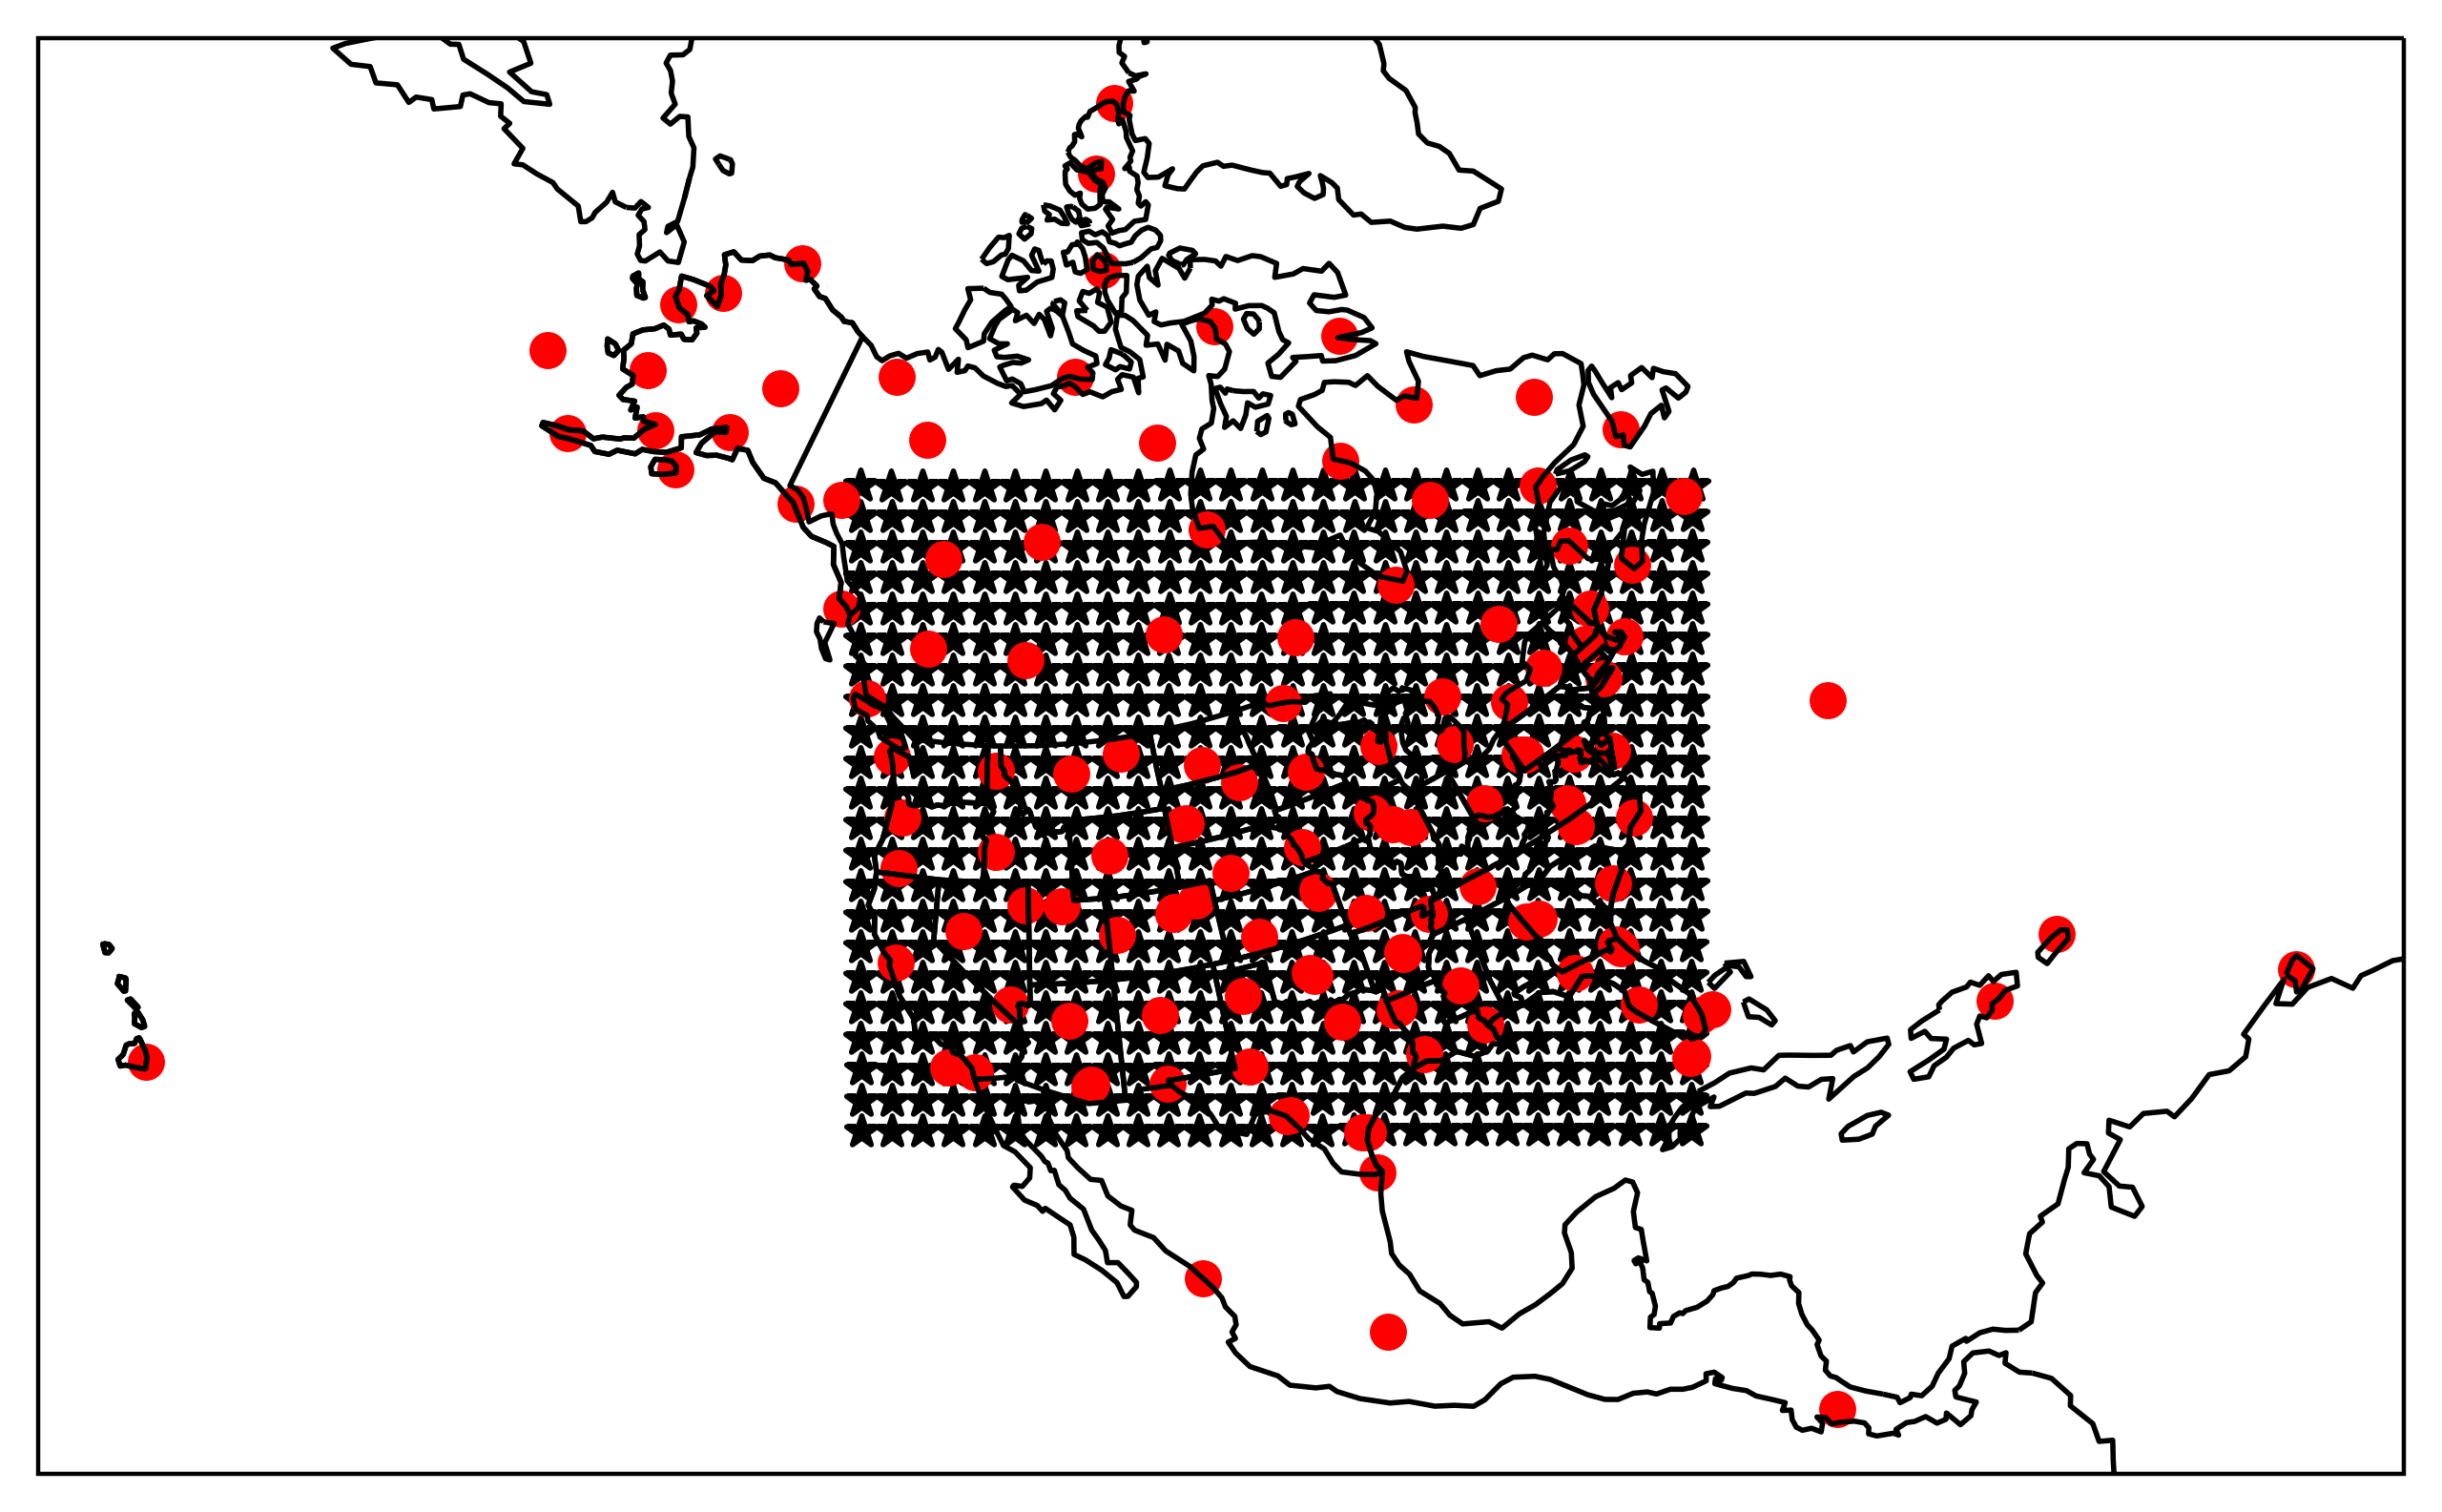

In [6]:
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90, true_scale_latitude = 60) #Creating my background map projection.
fig = plt.figure(figsize=(8,8),dpi=400)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES) #Adding background map features
ax1.add_feature(cfeature.COASTLINE)
ax1.scatter(gx, gy, transform = ccrs.PlateCarree(), marker='*', color='black') #Plotting my gridpoints like a scatterplot
ax1.scatter(obx,oby,transform = ccrs.PlateCarree(), marker='o', color='red') #Plotting my observation points.

In [7]:
roi1 = 10 #Establishing my radii of influence
roi2 = 20
roi3 = 6

rois = np.array([10,20]) #Brian tried to help and put this in here, it seems to work. Not sure what it does or if its still necessary
inds_w_in_roi = np.empty(()) #Empty array meant to contain the number of indicies per analysis point found within their radius of influence
n_analysis_array = np.empty((y_n, x_n, len(rois)))
analysis_arr = np.empty((y_n, x_n, len(rois)))

for i in range(len(xs)):
    for j in range(len(xs[i])):
        rel_x = xs[i,j] - x #The difference of the x values between my analysis point and all observation points
        rel_y = ys[i,j] - y #Same as above, but with y
        rel_rad = (rel_x **2 + rel_y **2)**0.5 #Distance formula to calculate the distance between the gridpoint and obs
        inds_w_in_roi = np.where(rel_rad<roi1)[0] #Saving the indicies only found within my radius of influence
        
        n_analysis_array[i,j,0] = len(inds_w_in_roi) #Saving this to use later to calculate averages
        #print(type(inds_w_in_roi))
        xk = rel_x[inds_w_in_roi].values #Creating an array of my delta x values found in the roi
        yk = rel_y[inds_w_in_roi].values #Creating an array of my delta y values found in the roi
        fk = height[inds_w_in_roi].values #Creating an array of my height values found at the above indicies 
        matrix_r = np.zeros((6,6)) #Creating empty matricies to hold my values in the next step
        matrix_o = np.zeros(6)
        
        for k in range(len(xk)):
            row1 = np.matrix([[1, xk[k], yk[k], xk[k]**2, yk[k]**2, xk[k]*yk[k]]]) 
            neo = row1.T*row1 #Creating my 6x6 matrix by multiplying the above 1x6 by its transverse
            matrix_o += np.array([fk[k],xk[k]*fk[k],yk[k]*fk[k],(xk[k]**2)*fk[k],(yk[k]**2)*fk[k],xk[k]*yk[k]*fk[k]]) #Creating my "o" array
            matrix_r += neo #Renaming Neo
            
        matrix_r = matrix_r / n_analysis_array[i,j,0] #Creating the averages for the values found in my matricies 
        matrix_o = matrix_o / n_analysis_array[i,j,0]
        C = np.linalg.inv(matrix_r) * np.matrix(matrix_o).T #Calculating out my "c" matrix by multiplying the inverse of my 6x6 by the transpose of my 6x1
        analysis_arr[i,j,0] = C[0,0] #Taking all the c_00 values and saving them into their own array.


In [8]:
np.savetxt('roi10analysis.txt', analysis_arr[:,:,0], delimiter=',') #Printing out the c_00 values for each analysis point into a text file
np.savetxt('roi10numberofobs.txt', n_analysis_array[:,:,0], delimiter=',') #Printing out the number of observations used at each analysis point into a text file

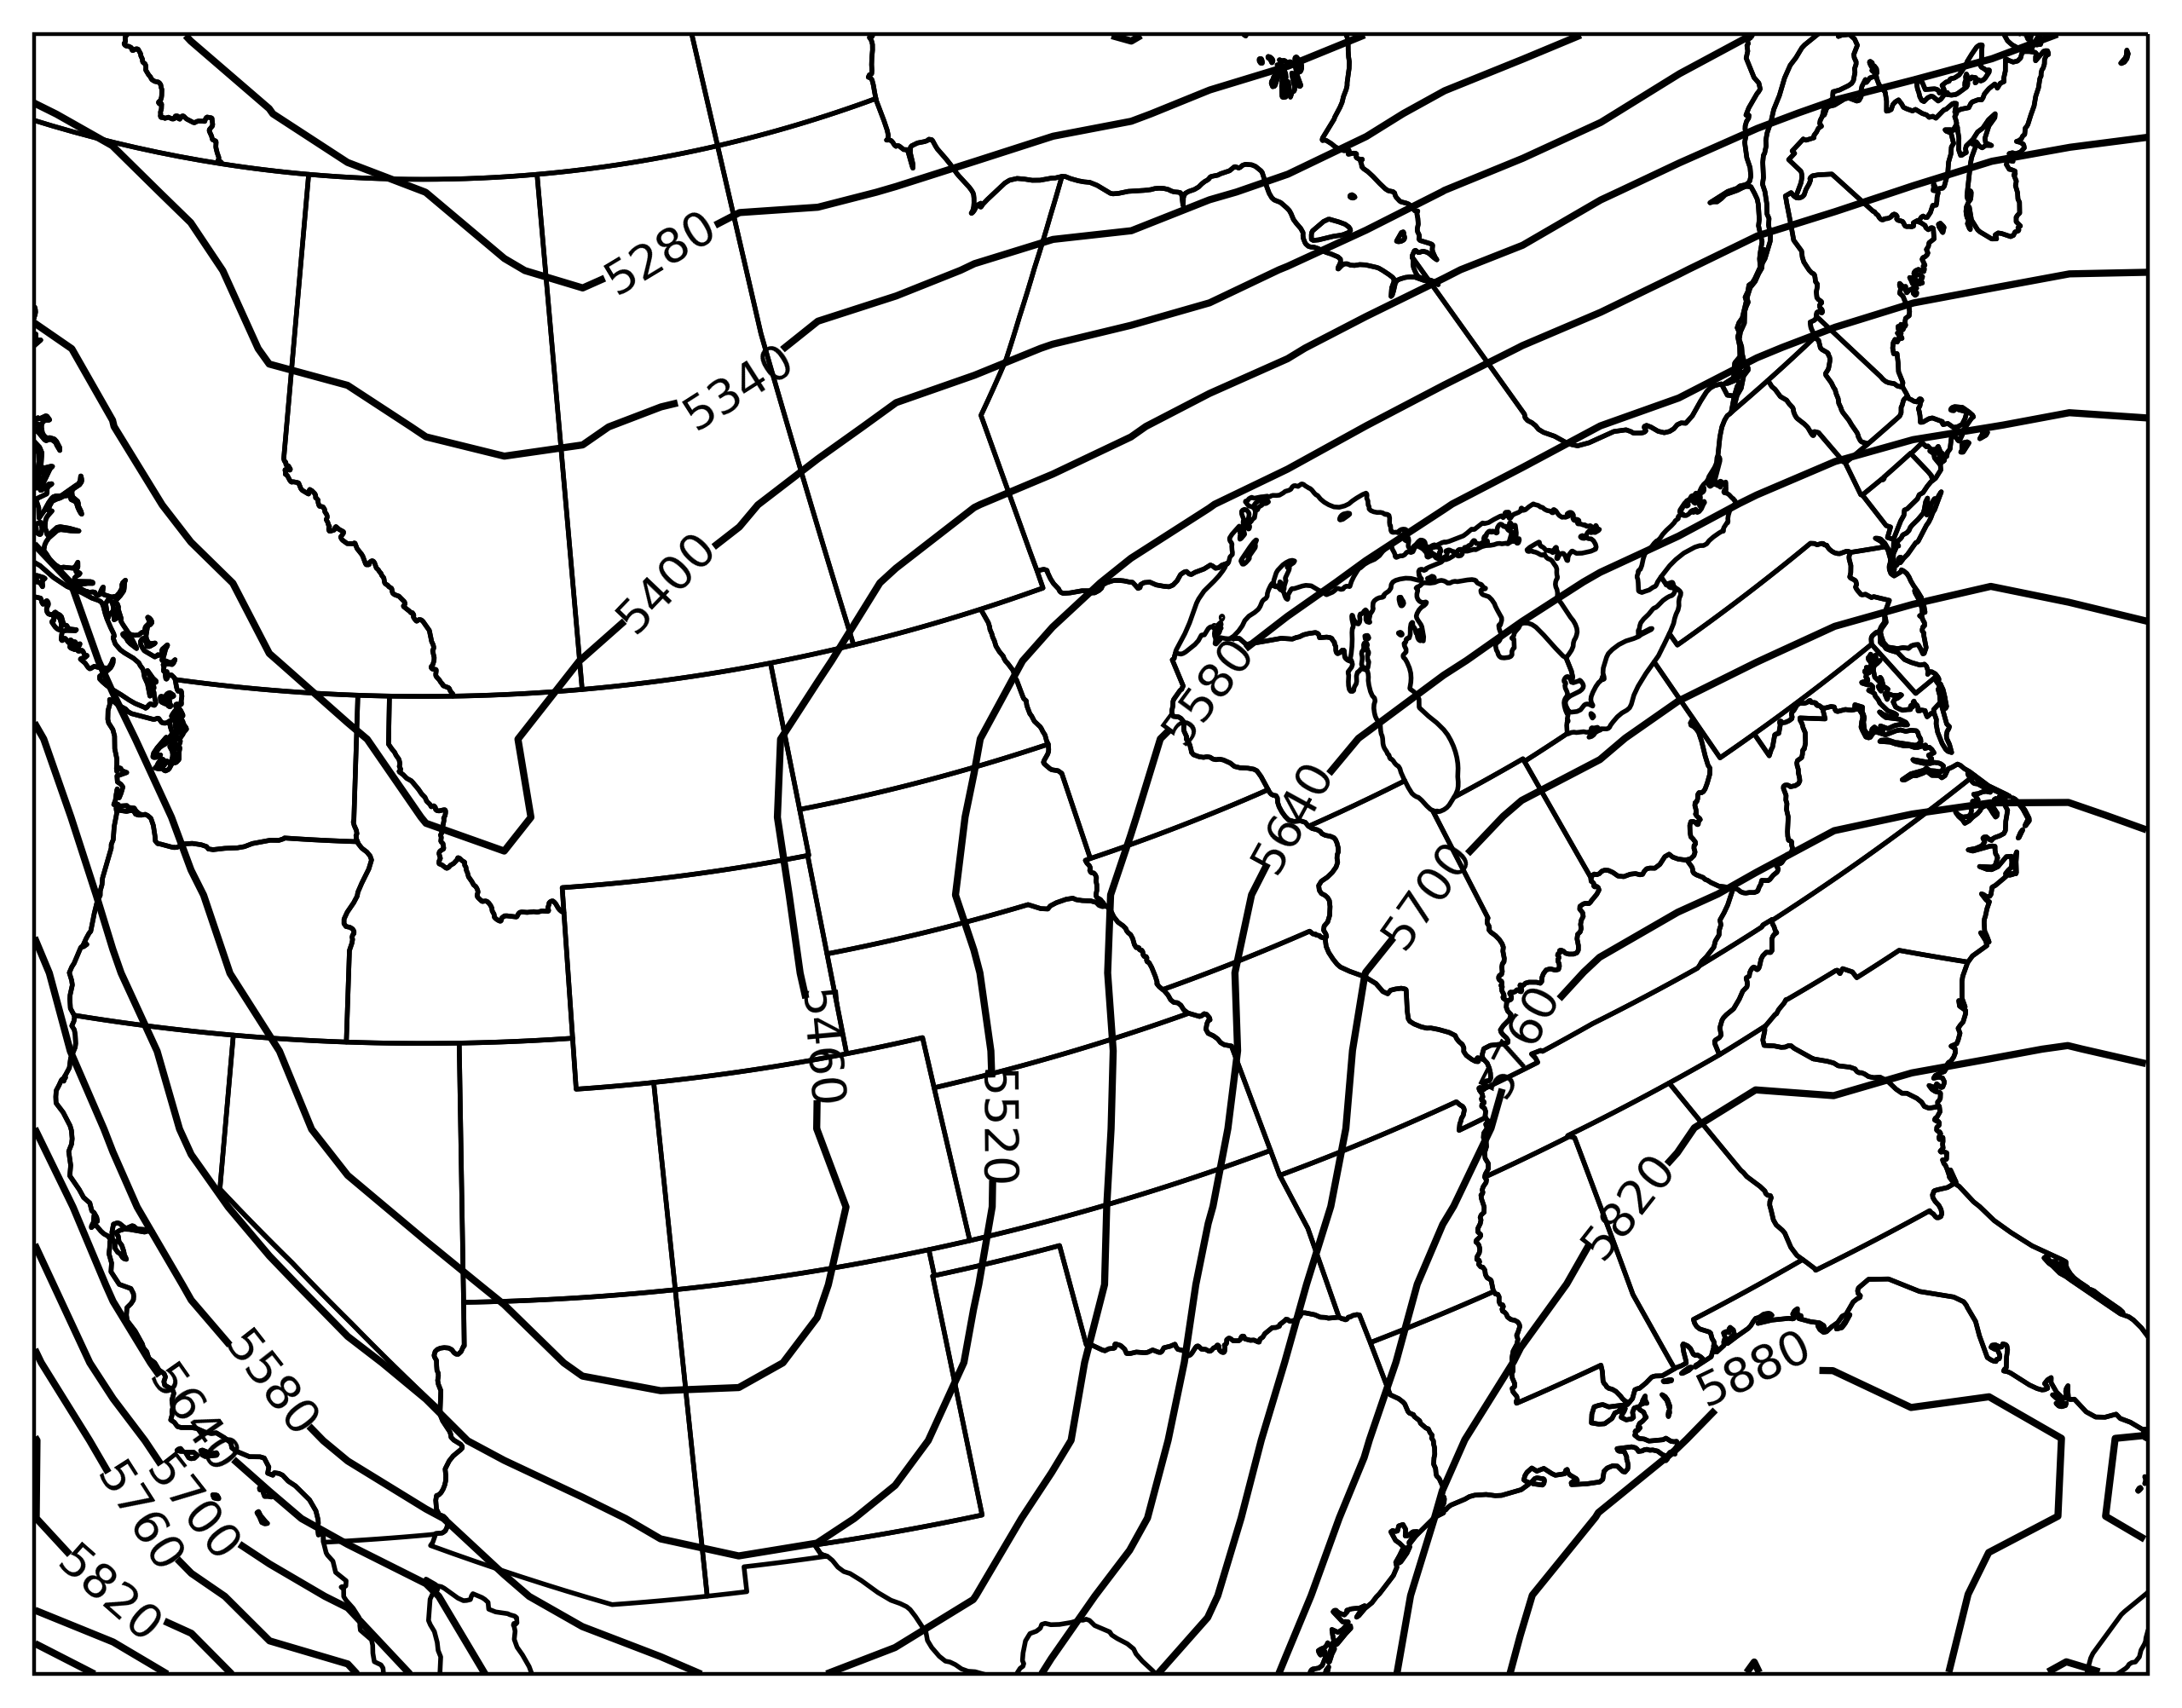

In [9]:
#Map 1

proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90, true_scale_latitude = 60) #Creating the polar-stereographic backround
fig = plt.figure(figsize=(8,8),dpi=400)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES) #Providing state boarders and coastlines to provide visual reference points
ax1.add_feature(cfeature.COASTLINE)
cs1 = ax1.contour(gx, gy, analysis_arr[:,:,0], colors = 'k', levels = np.arange(0,8000, 60), transform = ccrs.PlateCarree()) #Creating a contour plot of the values of my analysis array (My c_00 values) at each analysis point.
plt.clabel(cs1, levels = np.arange(0,8000,60)) #Labeling appropriately
plt.show() #I wanted to see the map

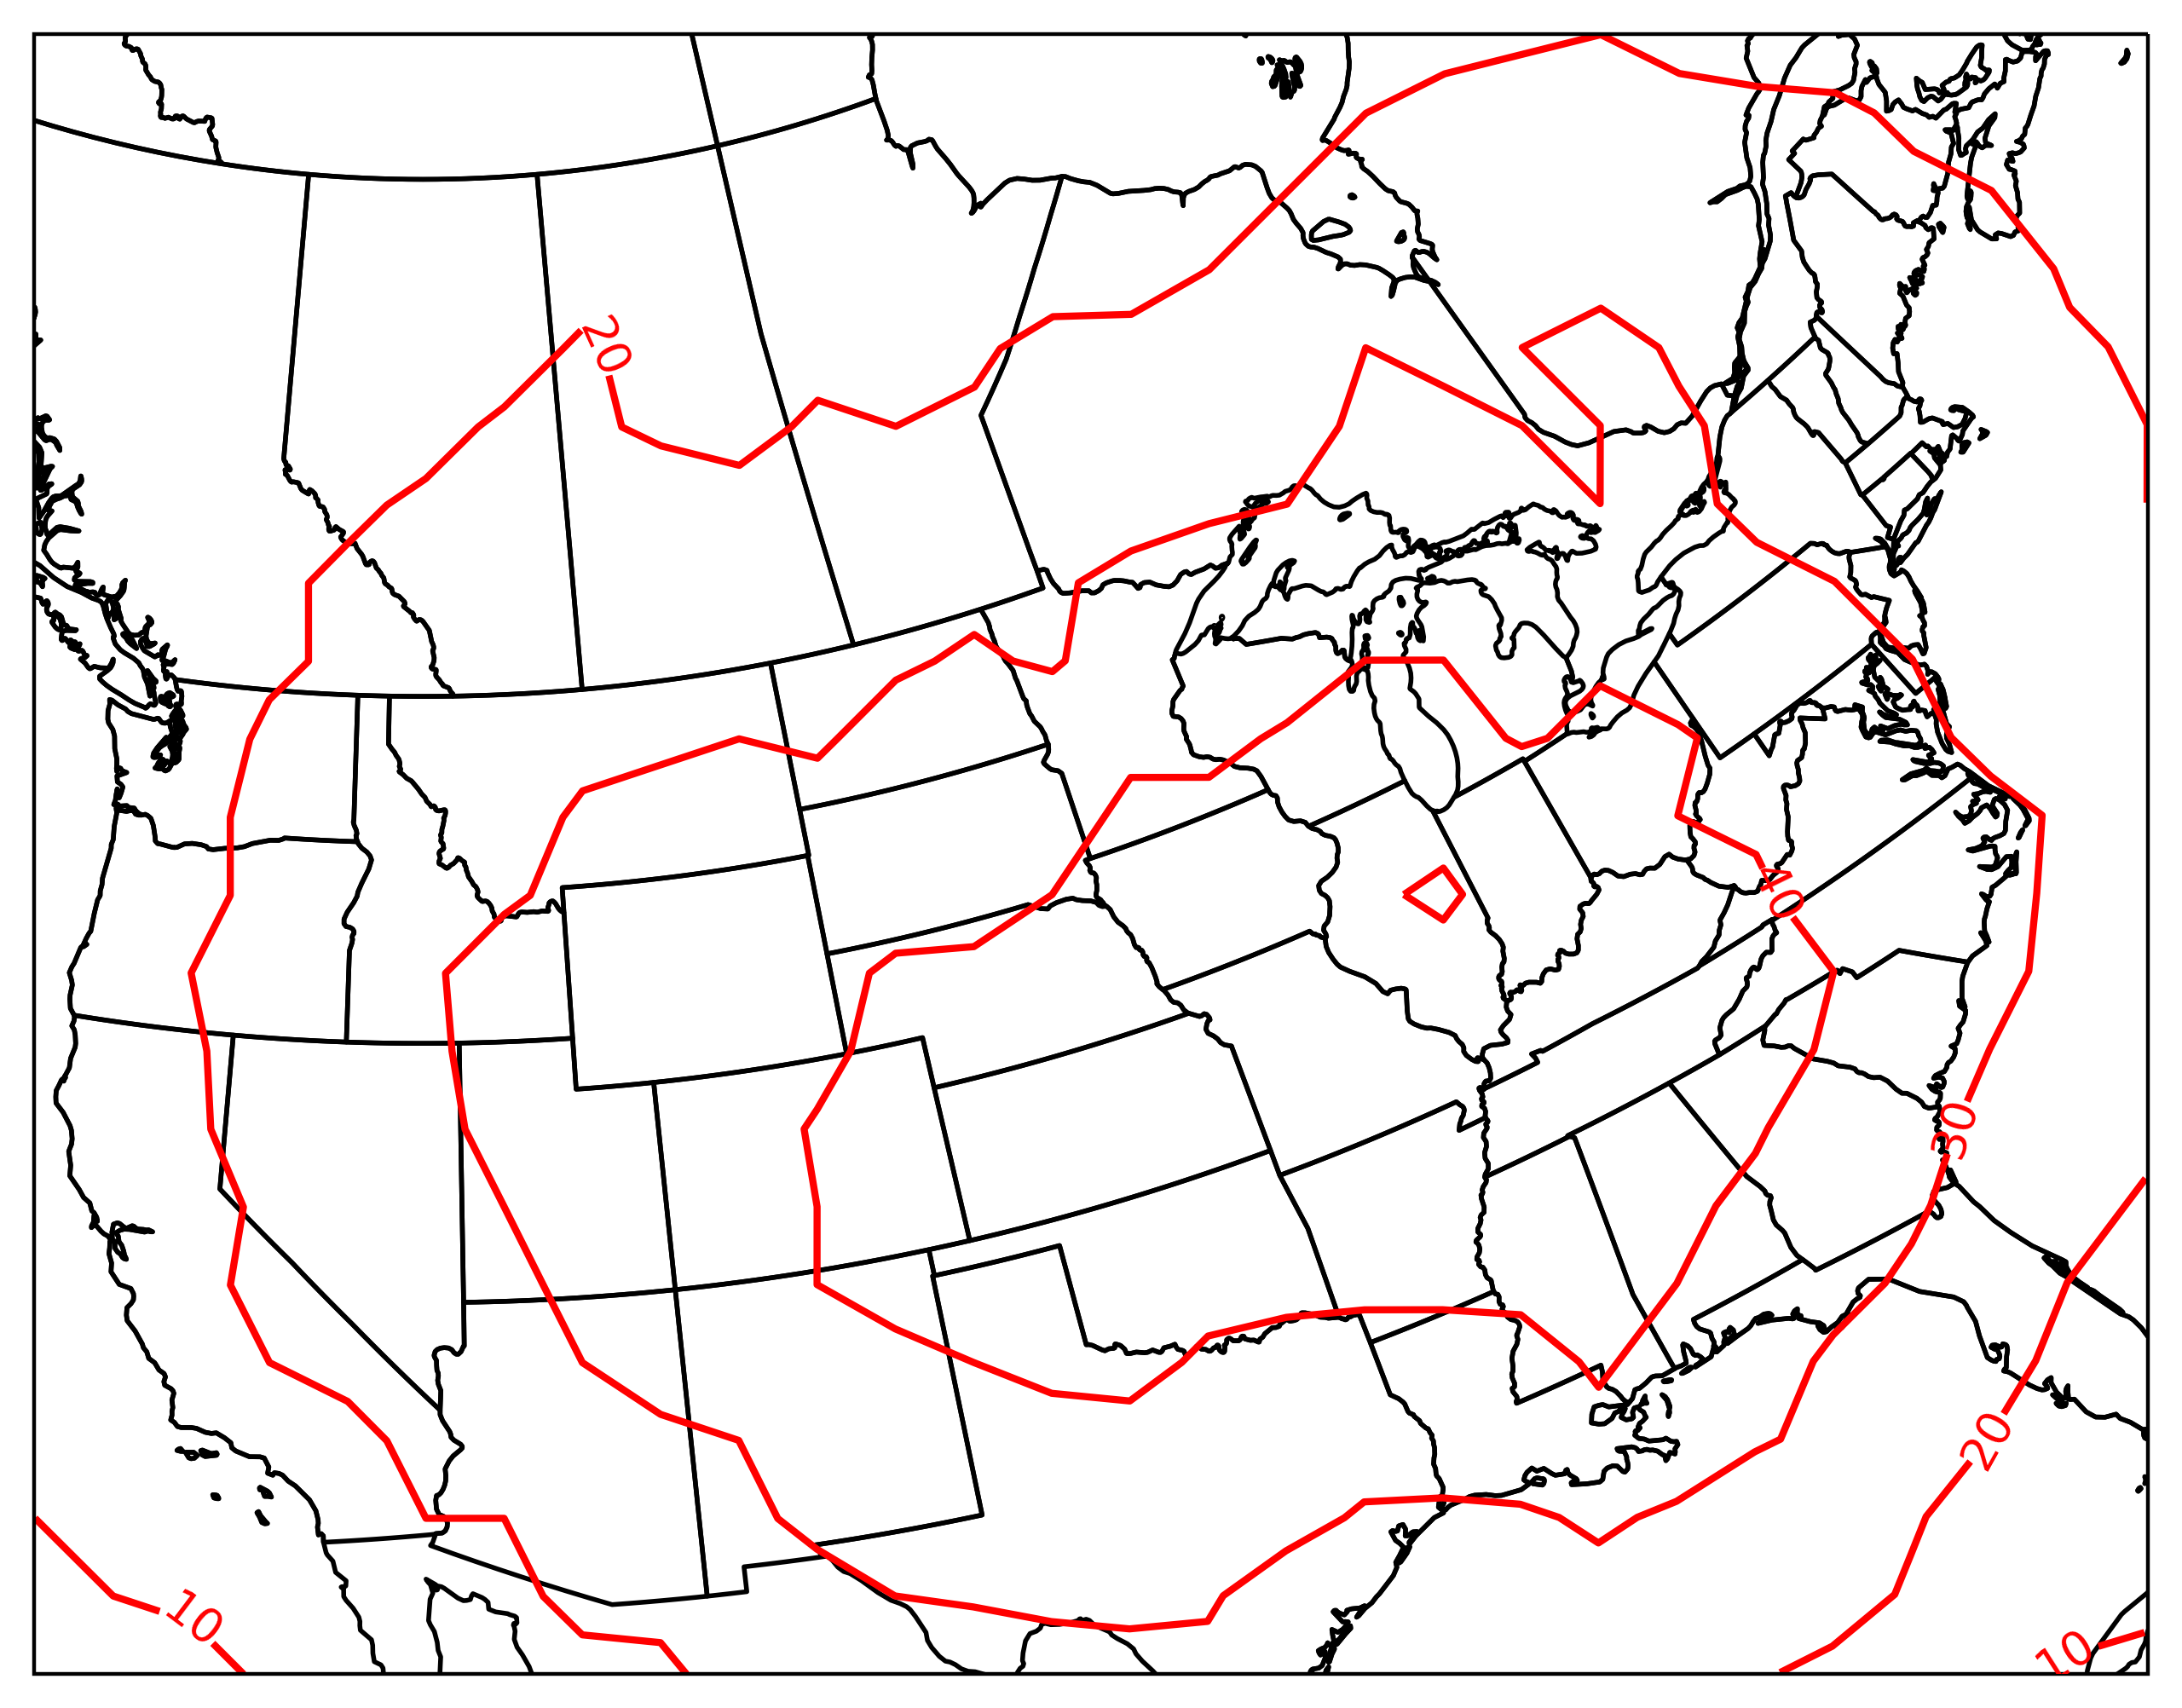

In [10]:
#Map 2
#See the comments of Map 1, the same things are being done with the exception of what is commented below. 

proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90, true_scale_latitude = 60)
fig = plt.figure(figsize=(8,8),dpi=400)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)
cs1 = ax1.contour(gx,gy,n_analysis_array[:,:,0], colors = 'r', levels = np.arange(0,1000,10), transform = ccrs.PlateCarree())
plt.clabel(cs1, levels = np.arange(0,1000,10)) #Creating a contour plot of number of observations used at each analysis point. Contour values and spacing chosen arbitrarily. 
plt.show()

In [11]:
#Doing the same as the similar block of code found above, this time with the radius of influence set at 20cm

n_analysis_array = np.empty((y_n, x_n, len(rois)))
analysis_arr = np.empty((y_n, x_n, len(rois)))


for i in range(len(xs)):
    for j in range(len(xs[i])):
        rel_x = xs[i,j] - x #The difference of the x values between my analysis point and all observation points
        rel_y = ys[i,j] - y
        rel_rad = (rel_x **2 + rel_y **2)**0.5 #Distance formula to calculate the distance between the gridpoint and obs
        inds_w_in_roi = np.where(rel_rad<roi2)[0] #Saving the indicies only found within my radius of influence
        
        n_analysis_array[i,j,0] = len(inds_w_in_roi) #Saving this for later to calculate the averages
        
        xk = rel_x[inds_w_in_roi].values #Creating an array of the x indicies found within my roi
        yk = rel_y[inds_w_in_roi].values #Same, but with y
        fk = height[inds_w_in_roi].values #Same, but with the height values
        matrix_r = np.zeros((6,6)) #Empty matricies to hold values in the next step
        matrix_o = np.zeros(6) #Same as above
        
        for k in range(len(xk)):
            row1 = np.matrix([[1, xk[k], yk[k], xk[k]**2, yk[k]**2, xk[k]*yk[k]]]) #Beginning stage of creating my 6x6 matrix
            neo = row1.T*row1 #By multiplying the above by its transverse, I get the 6x6
            matrix_o += np.array([fk[k],xk[k]*fk[k],yk[k]*fk[k],(xk[k]**2)*fk[k],(yk[k]**2)*fk[k],xk[k]*yk[k]*fk[k]]) #Creating the "o" matrix 
            matrix_r += neo #Renaming "Neo"
            
        matrix_r = matrix_r / n_analysis_array[i,j,0] #Dividing each value in my matrix by the number of values used for each analysis point. 
        matrix_o = matrix_o / n_analysis_array[i,j,0] #Same here, this is done to find the average values for each.
        C = np.linalg.inv(matrix_r) * np.matrix(matrix_o).T #To solve for my constants matrix, I multiply the inverse of my 6x6 with the transpose of my 1x6
        analysis_arr[i,j,0] = C[0,0] #Creates a new array containing only the c_00 values for each analysis point.


In [12]:
np.savetxt('roi20analysis.txt', analysis_arr[:,:,0], delimiter=',') #Printing out the c_00 values for each analysis point into a text file
np.savetxt('roi20numberofobs.txt', n_analysis_array[:,:,0], delimiter=',')#Printing out the number of observations used at each analysis point into a text file

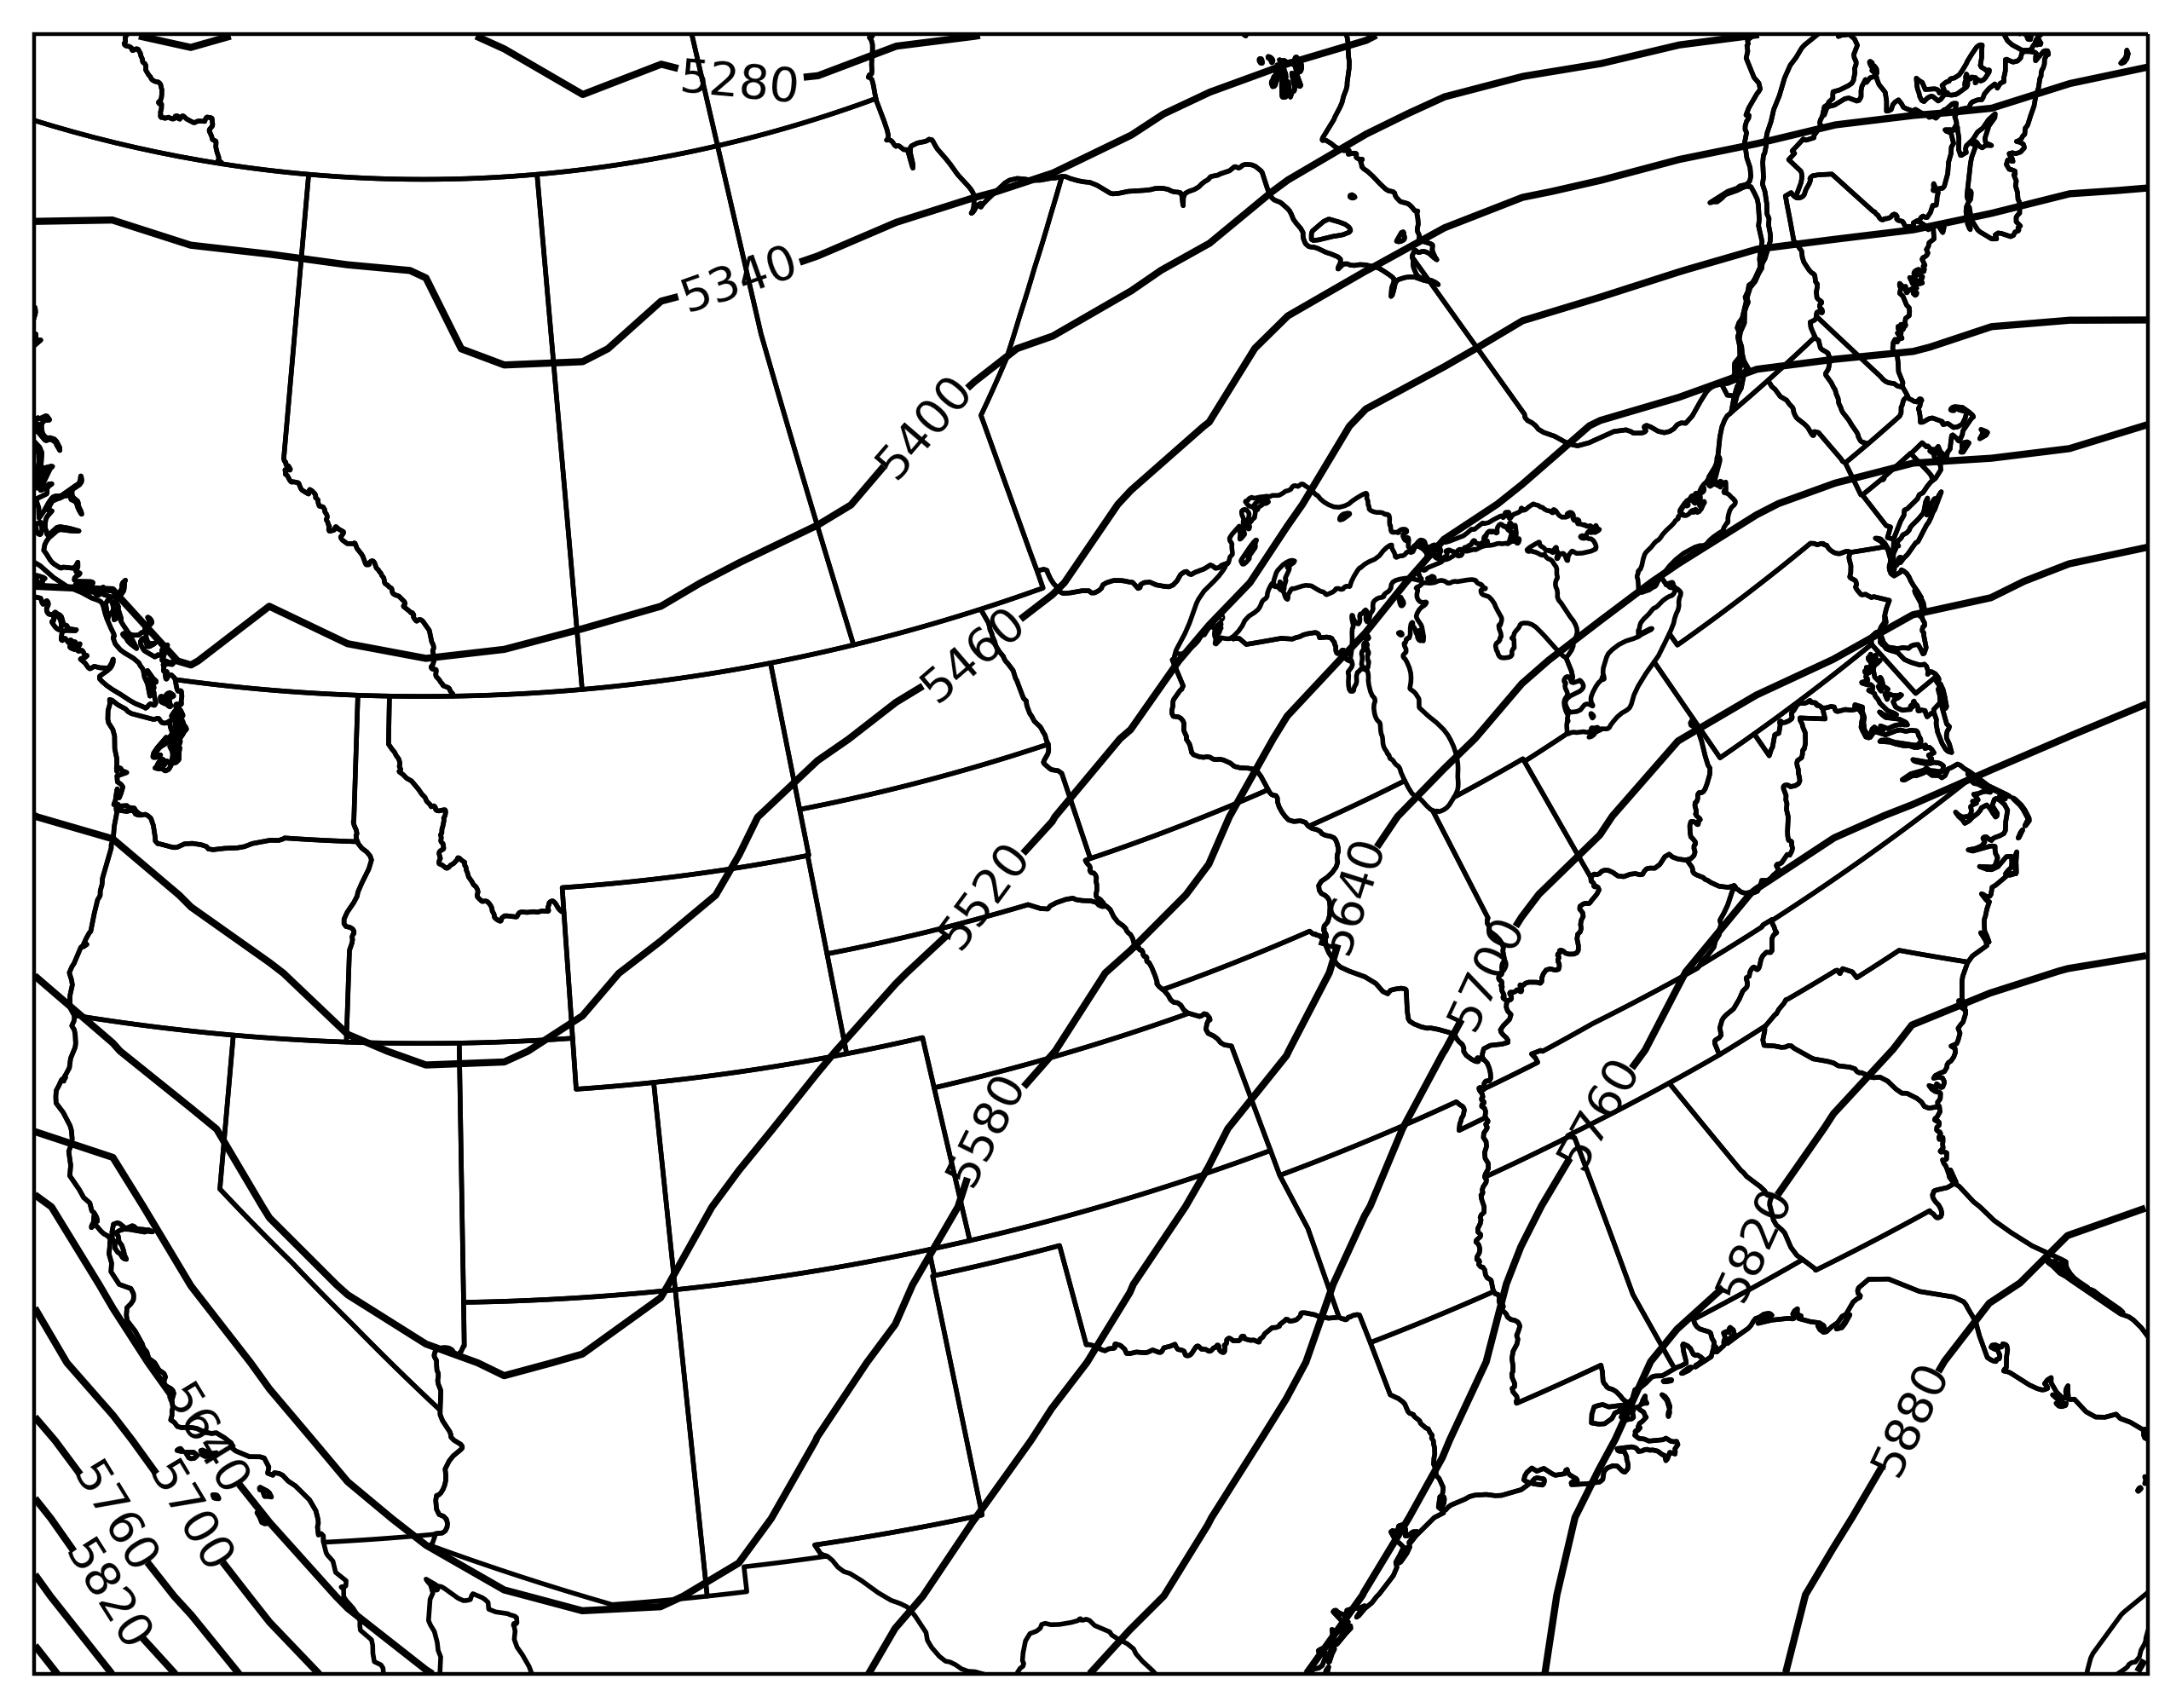

In [13]:
#Map 3
#See the comments of Map 1, the same things are being done with the exception of what is commented below. 

proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90, true_scale_latitude = 60)
fig = plt.figure(figsize=(8,8),dpi=400)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)
cs1 = ax1.contour(gx, gy, analysis_arr[:,:,0], colors = 'k', levels = np.arange(0,8000, 60), transform = ccrs.PlateCarree())
plt.clabel(cs1, levels = np.arange(0,8000,60))

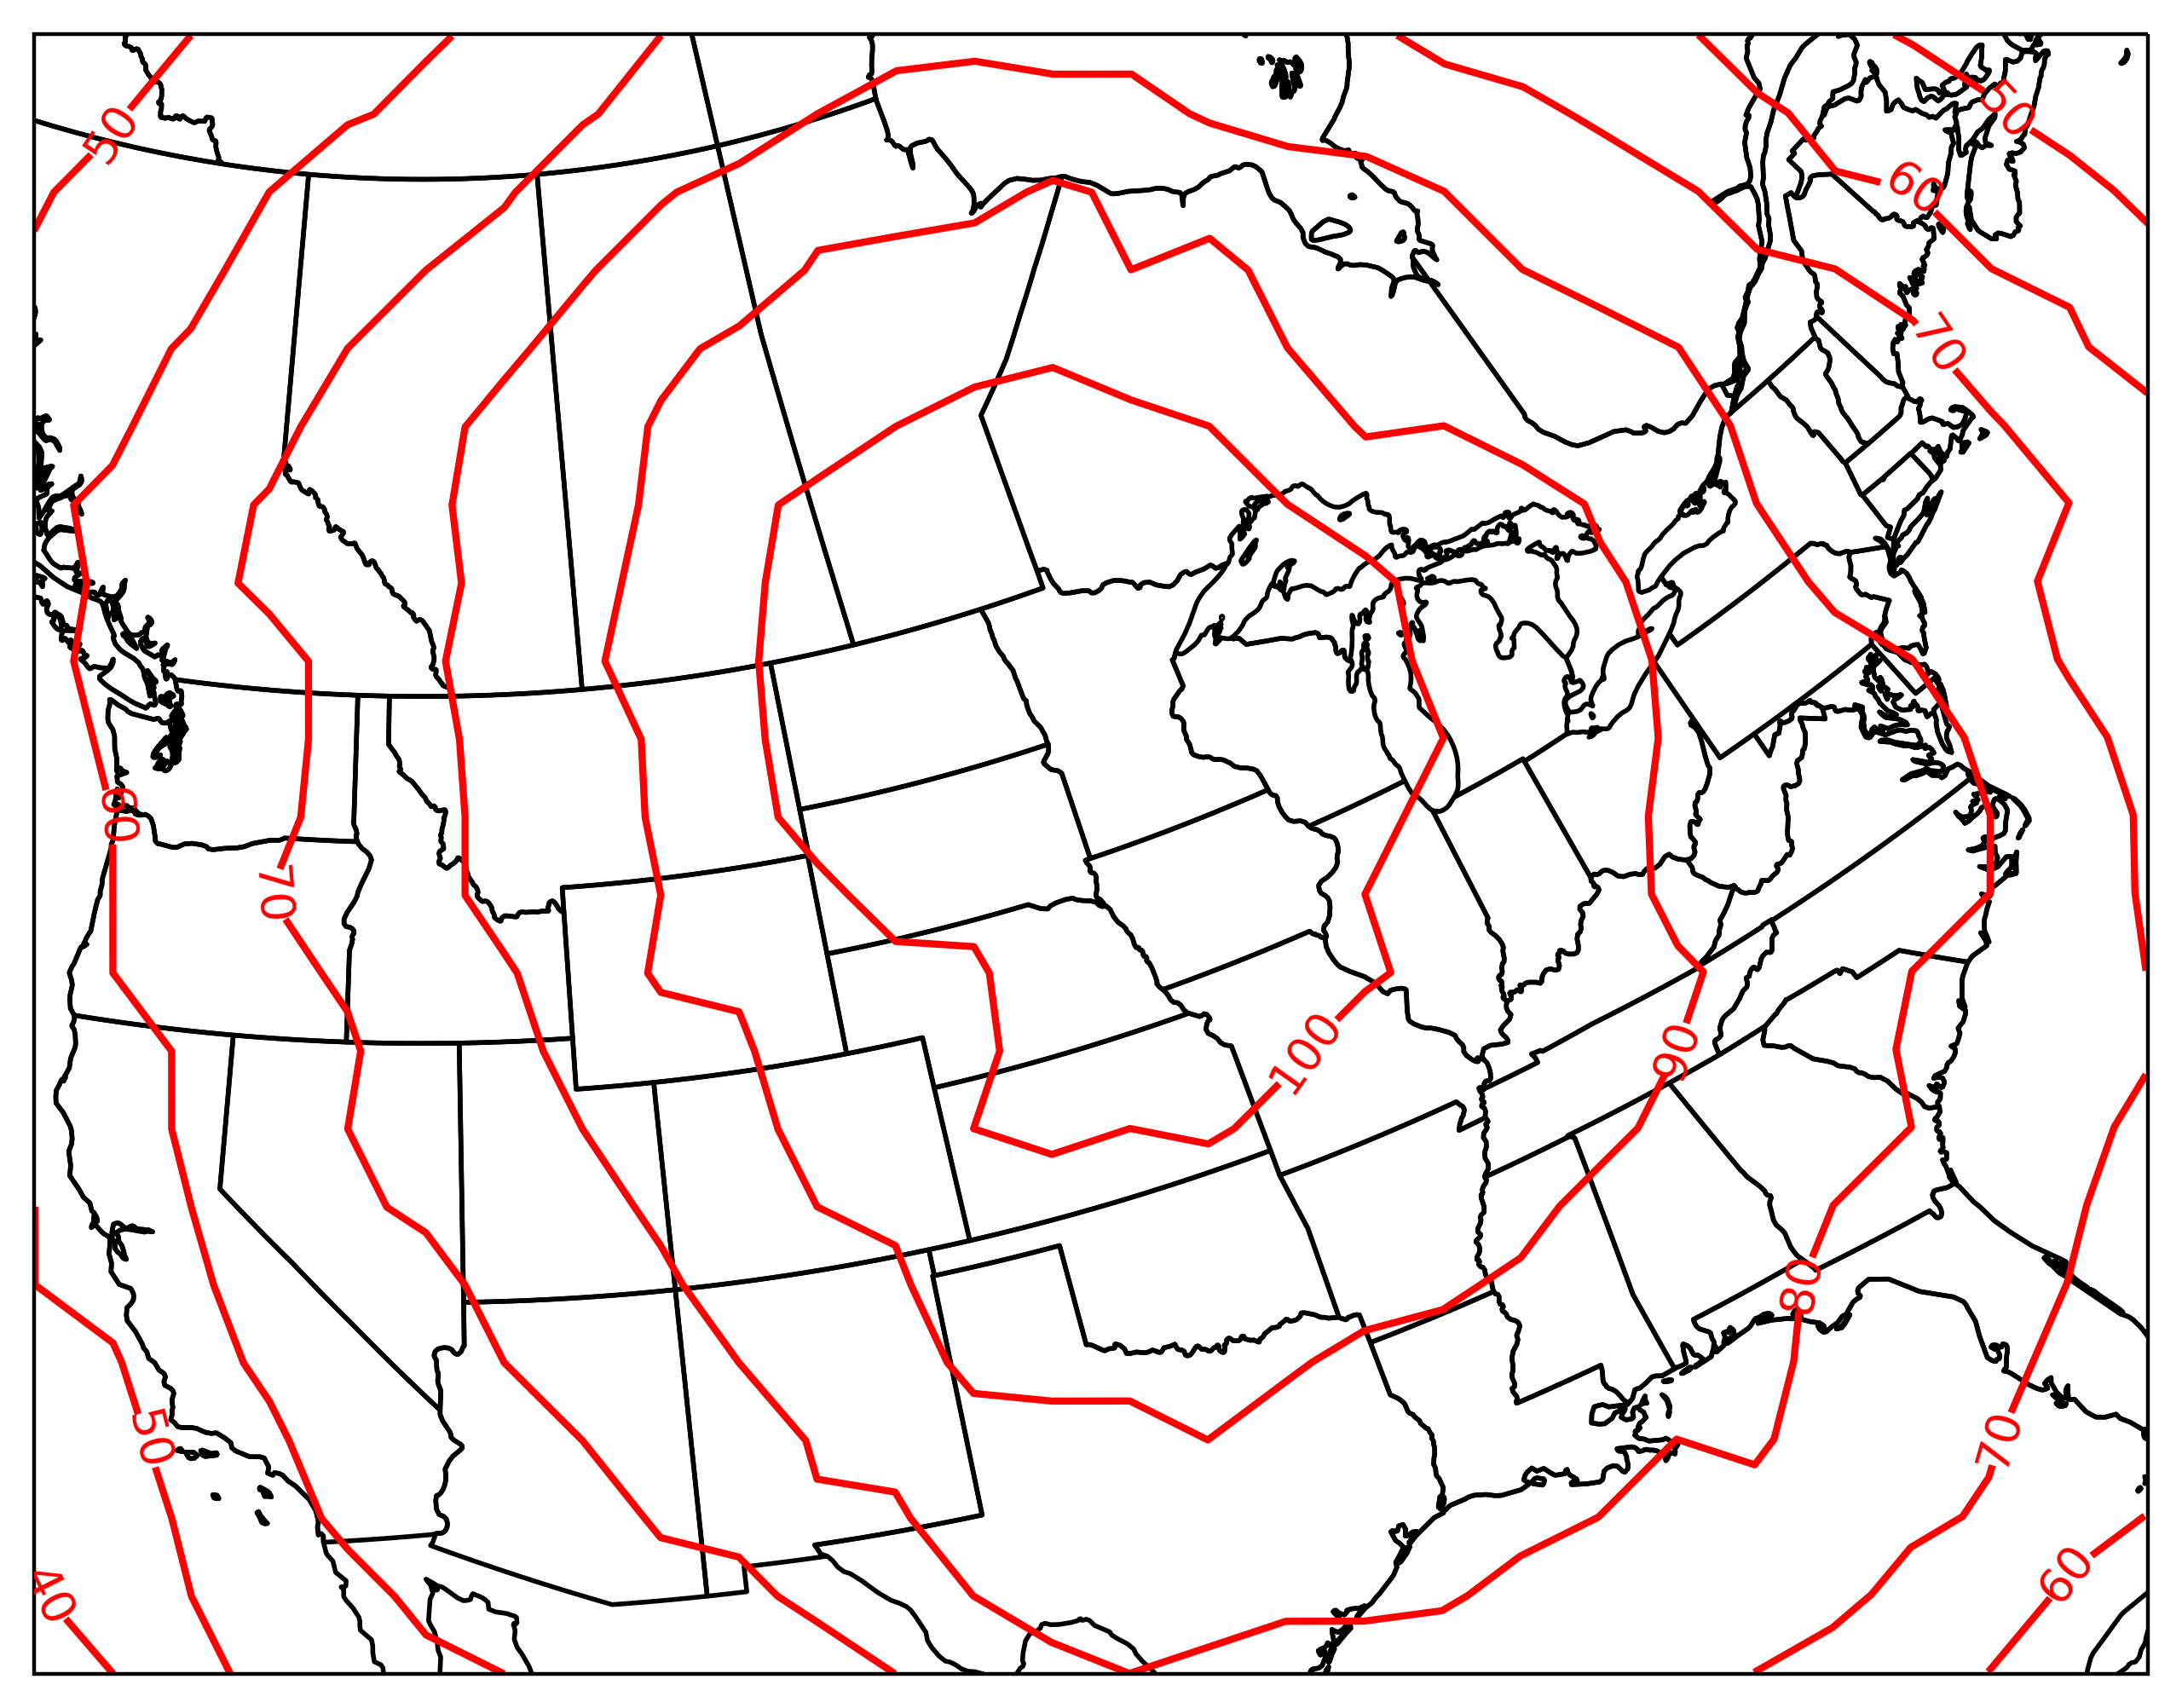

In [14]:
#Map 4
#See the comments of Map 2, the same things are being done with the exception of what is commented below. 
#Radius of Influence of 20cm

proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90, true_scale_latitude = 60)
fig = plt.figure(figsize=(8,8),dpi=400)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)
cs1 = ax1.contour(gx,gy,n_analysis_array[:,:,0], colors = 'r', levels = np.arange(0,1000,10), transform = ccrs.PlateCarree())
plt.clabel(cs1, levels = np.arange(0,1000,10))
plt.show()